# Establishing steady state and then getting energy balances to function

In [1]:
import numpy as np
import sympy
from matplotlib import pyplot as plt
import scipy
import scipy.optimize
import scipy.integrate
import CoolProp
import CoolProp.CoolProp as CP
import pandas as pd

In [2]:
def vle_data(xi):
    
    x_data = [0, 0.019, 0.0721, 0.0966, 0.1238, 0.1661, 0.2337, 0.2608, 
              0.3273, 0.3965, 0.5079, 0.5198, 0.5732, 0.6763, 0.7472, 0.8943, 1]
    y_data = [0, 0.170, 0.3891, 0.4375, 0.4704, 0.5089, 0.5445, 0.5580, 
              0.5826, 0.6122, 0.6564, 0.6599, 0.6841, 0.7385, 0.7815, 0.8943, 1]
    T_data = [100,95.5,89,86.7,85.3,84.1,82.7,82.3,81.5,80.7,79.8,79.7,79.3,
             78.74,78.41,78.15,78.30]
    x = np.interp(xi,x_data, y_data)
    T = np.interp(xi,x_data,T_data)
    return x,T

In [3]:
def feed_vector(plates,feedplate,feed):
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    feed_vec1 = np.zeros(plates)
    feed_vec2 = np.zeros(plates)
    flow_vec_top = np.zeros(plates)
    flow_vec_bot = np.zeros(plates)
    
    flow_vec_top[0:feedplate] = L1
    flow_vec_top[feedplate:] = L2
    
    flow_vec_bot[0:feedplate-1] = L1
    flow_vec_bot[feedplate-1:] = L2
    
    feed_vec1[feedplate-1] = feed
    feed_vec2[0] = R
    feed_vec2[-1] = BU
    
    return np.asarray([flow_vec_top,flow_vec_bot,feed_vec1,feed_vec2])
# feed_vector(12,4,1)

In [4]:
def comp_vector(xi,yi):
    
    xi = np.asarray(xi)
    yi = np.asarray(yi)
    
    xi1 = np.copy(xi)
    xi1 = np.roll(xi1, 1)
    xi1[0] = 0
    
    xi2 = np.copy(xi)
    xi2[-1] = 0
    
    yi1 = np.copy(yi)
    yi1 = np.roll(yi1, -1)
    yi1[-1] = 0
    
    yi2 = np.copy(yi)
    yi2[0] = 0
    
    
    return np.asarray([xi1,xi2]),np.asarray([yi1,yi2])

In [5]:
def holdup_vector(plates, m_cond,m_tray,m_rebl):
    holdup_vec = np.zeros(plates)
    
    holdup_vec[0] = m_cond
    holdup_vec[-1] = m_rebl
    holdup_vec[1:plates-1] = m_tray
    
    return holdup_vec

In [6]:
def mass_DE(t, x):
    
    xi = np.asarray(x)
    yi,_ = vle_data(xi)
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    Dist = V - L1
    Bottom = L2 - V
    
    if t<15:
        feedplate = 4
    else:
        feedplate = 4
    
    flow1, flow2, feed1, feed2 = feed_vector(plates,feedplate, F)
    x1, y1 = comp_vector(xi,yi)
    holdup_vec = holdup_vector(plates, m_cond,m_tray,m_rebl)
    
    dxdt = 1/holdup_vec * (V*(y1[0] - y1[1]) + flow1*x1[0] - flow2*x1[1] + feed1*xF  - feed2*xi)
                     
    return dxdt

## Establishing an initial steady state vector 

In [7]:
init = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# init = [0.71332218, 0.62858247, 0.56756165, 0.51559062, 0.51558868, 0.51557352,
#         0.51550557, 0.51508155, 0.51288654, 0.50231758, 0.4596435,  0.28665376]

plates = 12
feedplate = 4

F = 1 # Feed on plate 3
D =0.5
xF = 0.5 # mole fraction in feed
R_r = 10 # reflux ratio
m_cond = 0.15 # holdup in condenser
m_tray = 0.2 # holdup on each tray
m_rebl = 0.45 # holdup in reboiler

In [8]:
tspan = (0,50)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mass_DE, tspan, init, t_eval=t)

In [9]:
x = initial_run.y

[0.81021724 0.78461551 0.75434827 0.71072083 0.70871871 0.70477968
 0.6981517  0.68567944 0.66195058 0.61228895 0.49379769 0.18978498]


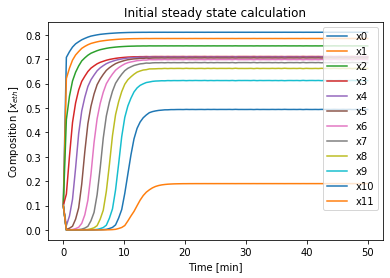

In [10]:
plt.figure(1)
plt.title("Initial steady state calculation")

for i in range(len(initial_run.y)) :
    plt.plot(t,initial_run.y[i], label="x{}".format(i))
    
plt.xlabel("Time [min]")
plt.ylabel("Composition [$x_{eth}$]")
plt.legend(loc = "upper right")

plt.savefig("Basic_distillation_column_V3.svg")
print(x[:,-1])

In [11]:
x_ss = [0.81021724 ,0.78461551 ,0.75434827, 0.71072083 ,0.70871871 ,0.70477968,
        0.6981517,  0.68567944 ,0.66195058 ,0.61228895 ,0.49379769, 0.18978498]
y_ss,T_ss = vle_data(x_ss)
steady_state = pd.DataFrame({'x_ss':x_ss, 'y_ss':y_ss, 'T_ss':T_ss})
steady_state

,x_ss,y_ss,T_ss
0,0.810217,0.829823,78.298617
1,0.784616,0.810191,78.343868
2,0.754348,0.786981,78.397365
3,0.710721,0.759376,78.579790
4,0.708719,0.758162,78.589109
5,0.704780,0.755773,78.607443
6,0.698152,0.751753,78.638293
7,0.685679,0.744189,78.696344
8,0.661951,0.730929,78.817941
9,0.612289,0.704725,79.087684


## Adding energy balance functions 

In [12]:
def H(xi,yi,Ti):
    Hi_L = []
    Hi_V = []
    Ti = np.asarray(Ti)
    
    for i in range(len(xi)):
        y = round(yi[i],5)
        Hi_L.append(CP.PropsSI('HMOLAR','P',101325,'Q',0,f'Ethanol[{xi[i]}]&Water[{1-xi[i]}]'))
        Hi_V.append(CP.PropsSI('HMOLAR','P',101325,'Q',1,f'Ethanol[{y}]&Water[{1-y}]'))
        
    Hi_L = np.asarray(Hi_L)
    Hi_V = np.asarray(Hi_V)
    
    Hi_L1 = np.copy(Hi_L)
    Hi_L1 = np.roll(Hi_L1, 1)
    Hi_L1[0] = 0
    
    Hi_L2 = np.copy(Hi_L)
    Hi_L2[-1] = 0
    
    Hi_V1 = np.copy(Hi_V)
    Hi_V1 = np.roll(Hi_V1, -1)
    Hi_V1[-1] = 0
    
    Hi_V2 = np.copy(Hi_V)
    Hi_V2[0] = 0
    
    Hi_F = np.zeros(plates)
    Hi_F[feedplate-1] = CP.PropsSI('HMOLAR','P',101325,'Q',0,f'Ethanol[{xF}]&Water[{1-xF}]')
    
    return [Hi_L,Hi_L1,Hi_L2,Hi_V,Hi_V1,Hi_V2,Hi_F]

In [13]:
def cond_duty(M,Tout):
    cp_w = CP.PropsSI('CPMASS','P',101325,'T',298,'Water')
    
    Qcond = M*cp_w*(Tout - 25)
    
    return Qcond
cond_duty(10.36528884,30)

216705.91250745376

In [14]:
def rebl_duty(M,Tout):
    cp_w = CP.PropsSI('CPMASS','P',500000,'T',400,'Water')
    
    Qcond = -M*cp_w*(Tout - 126)
    
    return Qcond
rebl_duty(1,100)

110625.57369639185

In [15]:
def duty(plates,feedplate,Qcond,Qrebl):
    duty_vector = np.zeros(plates)
    duty_vector[0] = Qcond

    duty_vector[-1] = Qrebl
    
    return duty_vector

In [16]:
def Cp(xi):
    CPi = []
    
    for i in range(len(xi)):
        CPi.append(CP.PropsSI('CPMOLAR','Q',0,'P',101325,f'Ethanol[{xi[i]}]&Water[{1-xi[i]}]'))
    return np.asarray(CPi)

## Vectorized model with energy balance

In [17]:
def mass_DE(t,var):
    
    # values for compositon and temperature is fed as a 1-D array and reshaped
    x,T = np.reshape(var,(2,-1))
    
    xi = np.asarray(x)
    Ti = np.asarray(T)
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    yi,T_fake = vle_data(xi) # change to vle_data() for interpolation of vapour liquid equilibrium
    
    
    if t<15:
        feedplate = 4
    else:
        feedplate = 4 # change this to vary which plate is fed on
    
    flow1, flow2, feed1, feed2 = feed_vector(plates,feedplate, F)
    
    x1, y1 = comp_vector(xi,yi)
    holdup_vec = holdup_vector(plates, m_cond,m_tray,m_rebl)

    # component mass balance 
    
    dxdt = 1/holdup_vec * (V*(y1[0] - y1[1]) + flow1*x1[0] - flow2*x1[1] + feed1*xF  - feed2*xi)
    
    
    HL,HL1, HL2, HV, HV1, HV2, Hi_F = H(xi,yi,Ti)
    CPi = Cp(xi)
    
    duty_vector = duty(plates,feedplate,-cond_duty(10.07916,30),rebl_duty(2.01,100))

#      Energy balance with coolprops  
    
    dTdt = 1/(holdup_vec*CPi)*( V*(HV1 - HV2) + flow1*HL1 - flow2*HL2 + feed1*HL - feed2*HL + F*Hi_F + duty_vector ) 
    
#     dTdt = np.zeros(len(Ti))  # Unhash this to just use mass balance

    didt = np.concatenate([dxdt, dTdt])

    return didt

## Use steady state values as initial condition

In [18]:
init = np.concatenate([x_ss,T_ss+273])
init

array([8.10217240e-01, 7.84615510e-01, 7.54348270e-01, 7.10720830e-01,
       7.08718710e-01, 7.04779680e-01, 6.98151700e-01, 6.85679440e-01,
       6.61950580e-01, 6.12288950e-01, 4.93797690e-01, 1.89784980e-01,
       3.51298617e+02, 3.51343868e+02, 3.51397365e+02, 3.51579790e+02,
       3.51589109e+02, 3.51607443e+02, 3.51638293e+02, 3.51696344e+02,
       3.51817941e+02, 3.52087684e+02, 3.52913932e+02, 3.56609483e+02])

In [19]:
mass_DE(0,init)

array([-9.56293587e-04,  1.77691091e-03, -2.47447055e-03,  3.68965113e-03,
       -5.63319795e-03,  7.62666375e-03, -9.17819450e-03,  9.52082879e-03,
       -8.73360330e-03,  7.03887926e-03, -4.62828078e-03,  7.58437081e-04,
        3.06527824e+02,  8.69474252e+00,  1.14899284e+01,  7.88463652e+01,
        1.37869003e+00,  1.42571075e+00,  3.98380704e+00,  5.82729553e+00,
        1.37373356e+01,  3.04820368e+01,  9.66099225e+01,  3.40375003e+01])

In [20]:
tspan = (0,15)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mass_DE, tspan, init, t_eval=t)

[8.10217240e-01 7.84615510e-01 7.54348270e-01 7.10720830e-01
 7.08718710e-01 7.04779680e-01 6.98151700e-01 6.85679440e-01
 6.61950580e-01 6.12288950e-01 4.93797690e-01 1.89784980e-01
 3.51298617e+02 3.51343868e+02 3.51397365e+02 3.51579790e+02
 3.51589109e+02 3.51607443e+02 3.51638293e+02 3.51696344e+02
 3.51817941e+02 3.52087684e+02 3.52913932e+02 3.56609483e+02]


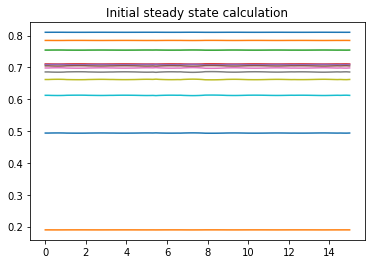

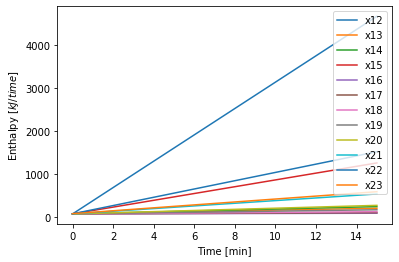

In [21]:
plt.figure(1)
plt.title("Initial steady state calculation")

plt.figure(1)
for i in range(0,12) :
    plt.plot(t,initial_run.y[i], label="x{}".format(i))

plt.figure(2)
for i in range(12,24) :
    plt.plot(t,initial_run.y[i]-273, label="x{}".format(i))
    
plt.xlabel("Time [min]")
plt.ylabel("Enthalpy [$kJ/time$]")
plt.legend(loc = "upper right")

print(initial_run.y[:,0])

## Now instead of trying to "balance" the temperatures lets just try the energy balance as it normally is 

In [162]:
def H(xi,yi):
    Hi_L = []
    Hi_V = []
    
    for i in range(len(xi)):
        y1 = round(yi[i],4)
        y2= round(1 - y1,4)
        Hi_L.append(CP.PropsSI('HMOLAR','P',101325,'Q',0,f'Ethanol[{xi[i]}]&Water[{1-xi[i]}]'))
        Hi_V.append(CP.PropsSI('HMOLAR','P',101325,'Q',1,f'Ethanol[{y1}]&Water[{y2}]'))
        
    Hi_L = np.asarray(Hi_L)
    Hi_V = np.asarray(Hi_V)
    
    Hi_L1 = np.copy(Hi_L)
    Hi_L1 = np.roll(Hi_L1, 1)
    Hi_L1[0] = 0
    
    Hi_L2 = np.copy(Hi_L)
    Hi_L2[-1] = 0
    
    Hi_V1 = np.copy(Hi_V)
    Hi_V1 = np.roll(Hi_V1, -1)
    Hi_V1[-1] = 0
    
    Hi_V2 = np.copy(Hi_V)
    Hi_V2[0] = 0
    
    Hi_F = np.zeros(plates)
    Hi_F[feedplate-1] = CP.PropsSI('HMOLAR','P',101325,'Q',0,f'Ethanol[{xF}]&Water[{1-xF}]')
    
    return [Hi_L,Hi_L1,Hi_L2,Hi_V,Hi_V1,Hi_V2,Hi_F]

In [163]:
def mass_DE(t,var):
    
    # values for compositon and temperature is fed as a 1-D array and reshaped
    x,Hi = np.reshape(var,(2,-1))
    
    xi = np.asarray(x)
    Hi = np.asarray(Hi)
    
    L1 = R_r*D
    V = L1 + D
    L2 = F + L1
    
    R = V - L1
    BU = L2 - V
    
    yi,T_fake = vle_data(xi) # change to vle_data() for interpolation of vapour liquid equilibrium
    
    
    if t<15:
        feedplate = 4
    else:
        feedplate = 4 # change this to vary which plate is fed on
    
    flow1, flow2, feed1, feed2 = feed_vector(plates,feedplate, F)
    
    x1, y1 = comp_vector(xi,yi)
    holdup_vec = holdup_vector(plates, m_cond,m_tray,m_rebl)

    # component mass balance 
    
    dxdt = (1/holdup_vec) * (V*(y1[0] - y1[1]) + flow1*x1[0] - flow2*x1[1] + feed1*xF  - feed2*xi)
    
    HL,HL1, HL2, HV, HV1, HV2, Hi_F = H(xi,yi)
    CPi = Cp(xi)
    
    duty_vector = duty(plates,feedplate,-cond_duty(10.36528884,30),rebl_duty(2.01,100))
#     duty_vector = duty(plates,feedplate,0,0)

#      Energy balance with coolprops  
    
#   Instead of doing the balance for the temperature on each plate

    dHdt = 1/holdup_vec*( V*(HV1 - HV2) + flow1*HL1 - flow2*HL2  - feed2*HL + F*Hi_F + duty_vector ) 

#  print(dHdt)
#     print(HL)
#     print(HV1)
#     print(HV2)
#     print(HL1)
#     print(HL2)
#     print(L1)
#     print(L2)
#     print(V)
#     print(D)

    
#     dTdt = np.zeros(len(Ti))  # Unhash this to just use mass balance
    didt = np.concatenate([dxdt, dHdt])

    return didt

## Get the initial conditions of the enthalpy from the steady state conditions

In [164]:
x_ss =[0.81021724 ,0.78461551 ,0.75434827, 0.71072083 ,0.70871871 ,0.70477968,
        0.6981517,  0.68567944 ,0.66195058 ,0.61228895 ,0.49379769, 0.18978498]
# x_ss = [0.5,0.5,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15]
Hi_ss = [0,0,0,0,0,0,0,0,0,0,0,0]

Hi_ss = []
y_ss,T_ss = vle_data(x_ss)
T_ss = T_ss + 273

for i in range(len(x_ss)):
    Hi_ss.append(CP.PropsSI('HMOLAR','T',T_ss[i],'Q',0,f'Ethanol[{x_ss[i]}]&Water[{1-x_ss[i]}]'))

In [165]:
init = np.concatenate([x_ss,Hi_ss])

In [166]:
mass_DE(0,init)[12:24]

array([-3.03721165e+00,  1.12156021e+03,  1.47336624e+03, -4.77311790e+01,
        1.76925222e+02,  1.75390389e+02,  5.12371717e+02,  7.42280664e+02,
        1.71398511e+03,  3.73224631e+03,  1.13095520e+04,  3.35989935e+03])

In [167]:
tspan = (0,15)
t = np.linspace( *tspan, 100)
initial_run = scipy.integrate.solve_ivp(mass_DE, tspan, init, t_eval=t)

[8.10234893e-01 7.84584390e-01 7.54393199e-01 7.10655667e-01
 7.08820352e-01 7.04644572e-01 6.98316793e-01 6.85510420e-01
 6.62107368e-01 6.12163658e-01 4.93879982e-01 1.89769855e-01
 4.94831064e+03 4.83382916e+02 5.21655113e+02 1.53731099e+03
 3.67175407e+02 3.79934543e+02 4.03441720e+02 4.47714285e+02
 5.50382932e+02 8.15376657e+02 1.79802874e+03 8.68008308e+02]


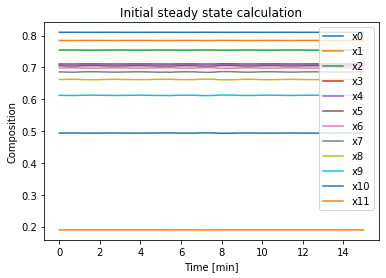

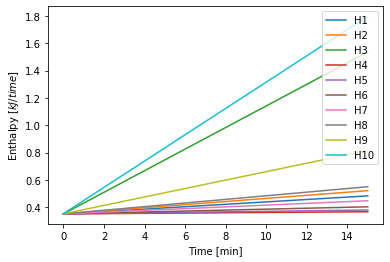

In [22]:
plt.figure(1)
plt.title("Initial steady state calculation")

plt.figure(1)
for i in range(0,12) :
    plt.plot(t,initial_run.y[i], label= f"x{i}")
    
plt.xlabel("Time [min]")
plt.ylabel("Composition")
plt.legend(loc = "upper right")

    
plt.figure(2)
for i in range(13,23) :
    plt.plot(t,initial_run.y[i]/1000, label=f"H{i-12}")
    
plt.xlabel("Time [min]")
plt.ylabel("Enthalpy [$kJ/time$]")
plt.legend(loc = "upper right")

print(initial_run.y[:,-1])

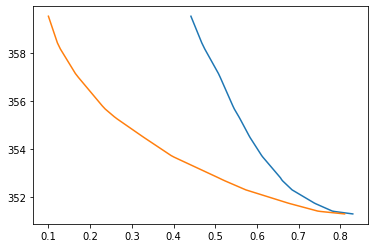

In [23]:
x = np.linspace(0.1,0.81,100)

y,T = vle_data(x)
T = T +273


plt.plot(y,T)
plt.plot(x,T)

In [24]:
Hi_L = []
Hi_V = []

for i in range(len(x)):
    yi = round(y[i],4)
    Hi_L.append(CP.PropsSI('HMOLAR','P',101325,'Q',0,f'Ethanol[{x[i]}]&Water[{1-x[i]}]'))
    Hi_V.append(CP.PropsSI('HMOLAR','P',101325,'Q',1,f'Ethanol[{yi}]&Water[{1-yi}]'))

In [35]:
sol  = initial_run.y
sol_x = sol[0:12,-1]
sol_H = sol[12:24,-1]

sol_y,_ = vle_data(sol_x)

HV = []

for i in range(len(sol_x)):
    yi = sol_y[i]
    HV.append(CP.PropsSI('HMOLAR','P',101325,'Q',1,f'Ethanol[{yi}]&Water[{1-yi}]'))
sol_y

array([0.82983675, 0.8101673 , 0.78701593, 0.7593363 , 0.7582232 ,
       0.75569064, 0.75185292, 0.74408601, 0.73101136, 0.7046589 ,
       0.6508373 , 0.52136519])

(0.3, 0.8)

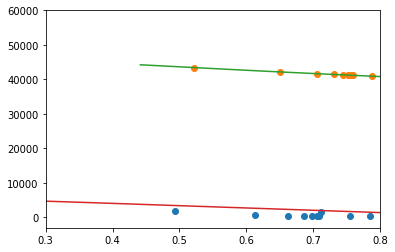

In [36]:
plt.plot(sol_x,sol_H,"o")
plt.plot(sol_y,HV,"o")


plt.plot(y,Hi_V)
plt.plot(x,Hi_L)
plt.ylim(-3000,60000)
plt.xlim(0.3,0.8)